In [23]:
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib as mpl
import matplotlib.pyplot as plt
import emcee, corner, time
from scipy.optimize import minimize
from scipy.stats import norm
from DHmodels import *

lsize = 16
mpl.rc('xtick',direction='in',top=True,labelsize=lsize) 
mpl.rc('ytick',direction='in',right=True,labelsize=lsize) 
mpl.rc('font',family='Times New Roman')
params = {'text.usetex': False, 'mathtext.fontset': 'stix',\
          'axes.labelsize': lsize, 'legend.fontsize': lsize, 'axes.grid' : True}
plt.rcParams.update(params)

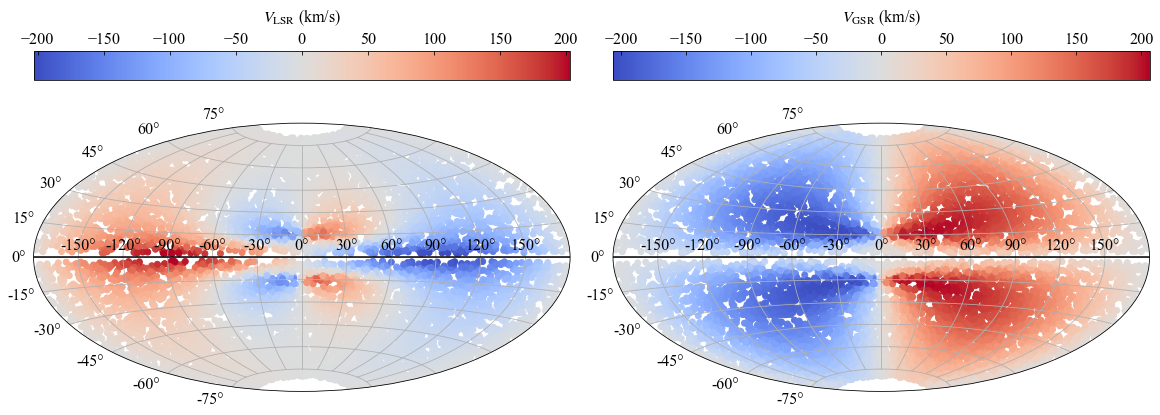

In [24]:
# Simulating a model with N random sightlines 
size = 10000
ls = np.random.uniform(-180,180,size=size)
bs = (2*np.random.randint(0,2,size=(size))-1)*np.random.uniform(1,80,size=size)     

# Parameters for the velocity field
velopars = (240,10,0,0)   # vflat,lag,vR,vz


# Parameters for the density field (see functions in file DHmodel.py for denspars)

#densmodel  = Constant_Density
#denspars   = (1E-04,)       #rho

#densmodel = FlatSandwich_Density
#denspars  = (1E-04,2.)      # N0, h0

densmodel = ThickSandwich_Density
denspars  = (1E-04,2,2.5)  # rho0, hmin, hmax

#densmodel = GaussianSandwich_Density 
#denspars  = (1E-04,3,0.4)   # rho0, h0, sigma

#densmodel = VerticalExponential_Density
#denspars  = (1E-04, 0.5)    # rho0, z0 

#densmodel = RadialVerticalExponential_Density
#denspars  = (1E-04, 5, 1.)  # rho0, R0, z0

# Calculating the model (it returns a Sightlines() object, see DHmodel.py)
slines = kinematic_model(ls,bs,velopars=velopars,densmodel=densmodel,denspars=denspars)

# And plotting the model
fig, ax = plot_model(slines)
#fig.savefig("mymodelpy.pdf",bbox_inches='tight')

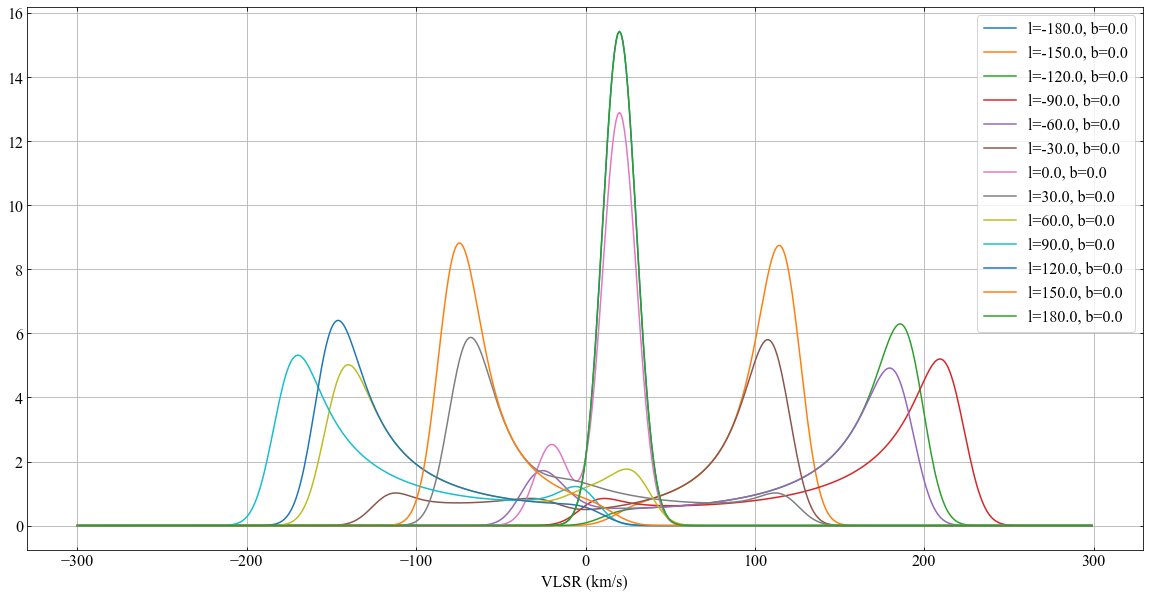

In [25]:
# We can even visualize the full spectra along some sightlines

ls = np.arange(-180,181,30)
bs = np.full(len(ls),.0)

velopars  = (240,15,20,-10)
densmodel = VerticalExponential_Density
denspars  = (1E-04,4)

s = kinematic_model(ls,bs,velopars=velopars,densmodel=densmodel,denspars=denspars,getSpectra=True)

plt.figure(figsize=(20,10))
for i in range(s.n):
    plt.plot(s.spec_grid,s.spec[i],label='l=%.1f, b=%.1f'%(s.lon[i],s.lat[i]))
plt.xlabel("VLSR (km/s)")
plt.legend()
#plt.savefig("spectra.pdf")

In [26]:
# Now we try a fit to the data 

# Loading the data
ds = pd.read_table("data/sightlines_flag_2.txt", sep=' ', skipinitialspace=True)

# Here we chose which ion we want to fit
ion = 'CIV'
di = ds[ds['ion']==ion]

# We select only latitudes below 60 deg for the fit
glon, glat, vl = di['Glon'].values, di['Glat'].values, di['weighted_v_LSR'].values
glon[glon>180] -= 360
m = (np.abs(glat)<60)
# Just storing the data in a Sightline object for convenience
data = Sightlines()
data.add_sightlines(glon[m],glat[m],vl[m],None,None)
print (f"Sightlines to fit: {len(data.lon)}")

Sightlines to fit: 100


In [27]:
# Let's try to use a FlatSandwich model, we fit for vflat, the lag, vz and h0 only

# Defining initial parameters
p0     = [230, 15, -5, 1]               # Initial guesses
labels = ["vflat", "lag","vz", "h0"]    # Names of parameters to fit

# For the MCMC analysis, we need a prior and a likelihood, defined below

# Prior for FlatSandwich model
def lnprior(pars):
    vflat, lag, vz, h0 = pars
    if vflat<0 or lag<0 or h0<0:
        return -np.inf
    # We use Gaussian priors (pdfs)
    h_prior   = norm.pdf(h0,loc=5,scale=2)
    lag_prior = norm.pdf(lag,loc=10,scale=2)
    vf_prior  = norm.pdf(vflat,loc=240,scale=20)
    vz_prior  = norm.pdf(vz,loc=0,scale=10)
    prior = np.log(h_prior*lag_prior*vz_prior*vf_prior)
    return prior


# Likelihood for FlatSandwich model
def lnlike(pars,data):
    # Extracting parameters (note that we do not fit the density at the moment)
    vf, lag, vz, h0 = pars
    densmod  = FlatSandwich_Density
    velopars = (vf,lag,0.,vz)
    denspars = (1E-04,h0)
    # Calculating the model
    mod = kinematic_model(data.lon,data.lat,velopars=velopars,densmodel=densmod,\
                          denspars=denspars,useC=True,nthreads=4)
    # Using the squared difference between model and data as metric
    diff = np.nansum((mod.vlsr-data.vlsr)**2)
    return -diff


# This is the prior*likelihood
def lnprob(pars,data):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(pars,data)

nll = lambda *args: -lnprob(*args)

In [28]:
# As a first attempt, we can just fit with a classical method like the Nelder-Mead. 
# This may work in some cases, but in other it may get stuck in a local minimum.

soln = minimize(nll, p0, args=(data),method='Nelder-Mead')
print ("Best-fit parameters:", labels, " = ", soln.x)

Best-fit parameters: ['vflat', 'lag', 'vz', 'h0']  =  [224.91402094  10.03623186 -11.54409135   0.2404545 ]


In [29]:
# Now let's go with an MCMC
# NB: THIS CAN BE EXTREMELY SLOW IN JUPYTER, BECAUSE PARALLELIZATION DOES NOT WORK HERE. BETTER TO USE THE fitmodel.py file

# Initializing chains and walkers
ndim, nwalkers, nsteps = len(p0), 500, 500
pos = p0 + 1e-1*np.random.randn(nwalkers,ndim)

# And now we go... (see emcee docs for details on what it is doing)
print ("\n Running MCMC...")
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data])
start = time.time()
res = sampler.run_mcmc(pos, nsteps, progress=True)
multi_time = time.time()-start
print("Computational time {0:.1f} minutes".format(multi_time/60.))

You must install the tqdm library to use progress indicators with emcee



 Running MCMC...
Computational time 1.3 minutes


Text(0.5, 0, 'step number')

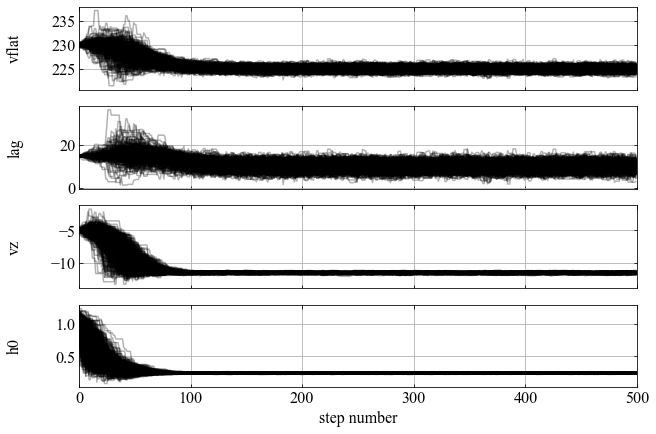

In [16]:
# Plotting chains 
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
#fig.savefig(f"{ion}_chains.png")

# Saving samples if want to keep them
# fits.writeto(f"{ion}_samples.fits",np.float32(sampler.get_chain()),overwrite=True)


In [17]:
# Now we calculate best-fit parameters from posterior distributions

# We get rid of the first 100 iterations, as chains arent stable yet (see plot above)
burnin = 100
thin = 1
samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)

# Calculating central values and 1-sigma deviations
print ("\n MCMC parameters:")
pp = []
for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [15.865, 50, 84.135])
    q = np.diff(mcmc)
    txt = "%10s = %10.3f %+10.3f %+10.3f"%(labels[i],mcmc[1], -q[0], q[1])
    print (txt)
    pp.append(mcmc[1])


 MCMC parameters:
     vflat =    224.940     -0.518     +0.526
       lag =     10.152     -2.034     +2.010
        vz =    -11.542     -0.113     +0.114
        h0 =      0.240     -0.006     +0.006


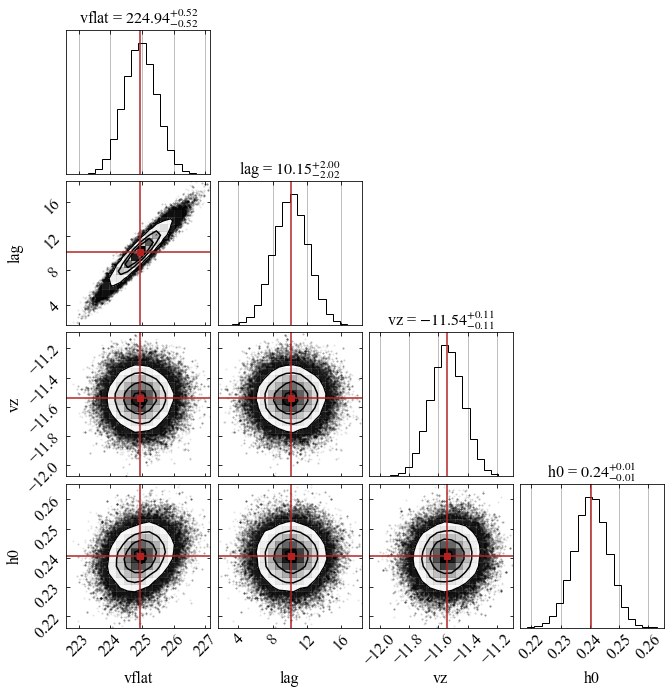

In [18]:
# Best way to visualize posterior distributions is a corner plot

# Contour levels 
fig = corner.corner(samples, truths=pp, labels=labels, show_titles=True, title_kwargs={"fontsize": lsize},truth_color='firebrick')
#fig.savefig(f"{ion}_corner.pdf",bbox_inches='tight')

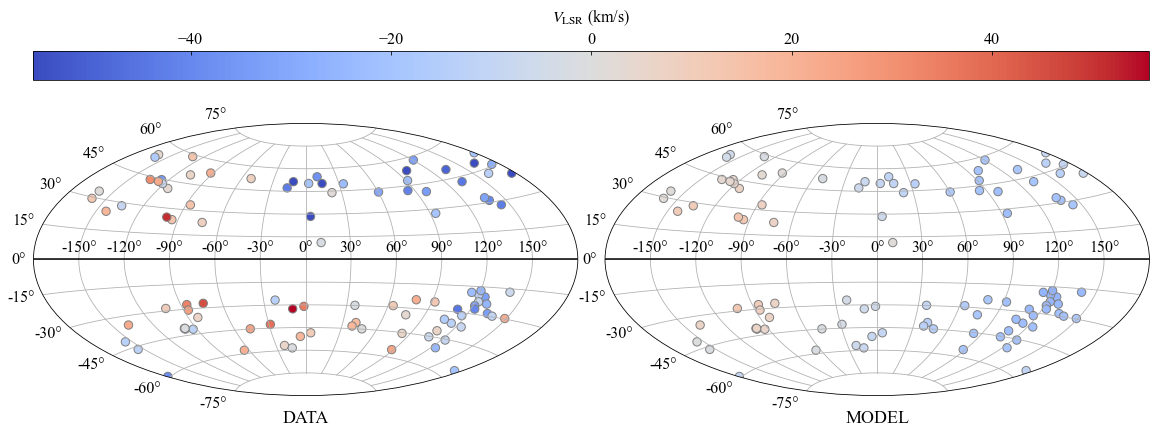

In [20]:
# We can finally compare our best-fit model to the data
model = kinematic_model(data.lon,data.lat,velopars=(pp[0],pp[1],0,pp[2]),densmodel=FlatSandwich_Density,\
                        denspars=(1E-04,pp[3]),useC=True,nthreads=8,getSpectra=False)
    
fig, ax = plot_datavsmodel(data,model)
#fig.savefig(f"{ion}_comp.pdf",bbox_inches='tight')